In [14]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import pandas as pd
import seaborn as sns

#for plot with ATLAS styple
import matplotlib.pyplot as plt
from matplotlib import colors

import uproot
import gc

from cells import Cells 

MCdata="cell_analysis_mu60"
MC_root = f"../re21.9/{MCdata}/cells.root"
tree_name = "ntuple"
        
x_bin = np.linspace(-3.15, 3.15, num=33)
y_bin = np.linspace(-5, 5, num=51)

cell_data = Cells(MC_root, unit="GeV")
#cell_imgs, cell_label = cell_data.cimg(x_bin, y_bin, batch_size=500)
cell_imgs, cell_label = cell_data.cimg_et(x_bin, y_bin, batch_size=500)
print(f"Cell image shape: {cell_imgs.shape}")
print(f"Image label shape: {cell_label.shape}")

gc.collect()

input_shapes = cell_imgs.shape[1:]
dim_fletten = np.prod(input_shapes)
print(f"dim_fletten = {dim_fletten}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Cell image shape: (47000, 50, 32)
Image label shape: (47000, 1)
dim_fletten = 1600


# prepare data

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import os

def plot_loss(history, output_path):
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        #plt.ylim([0.01, 15000])
        plt.yscale('log')
        if 'val_accuracy' in history.history.keys():
            plt.plot(history.history['val_accuracy'], label='val_acc')
        plt.xlabel('Epoch')
        plt.ylabel('Error ')
        plt.savefig(f"{output_path}/loss.pdf")
        plt.legend()
        
        plt.grid(True)
        
def train_dnn_model(model, x_train, y_train, epochs=20, model_path="model_weights",
                     train=True, best_model=True):
      

    print(f"x_train shape: {x_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    
    os.makedirs(model_path, exist_ok = True)
    checkpoint_filepath = f"./{model_path}/best_model"
    save_best_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_filepath,
                                                    save_weights_only=True,
                                                    monitor='val_mean_absolute_error',
                                                    mode='min',
                                                    save_best_only=True,
                                                    )
    if train:
        history = model.fit(x_train, y_train, 
                        batch_size= 1024,
                        epochs=epochs, 
                        verbose=0, validation_split=0.2,
                        callbacks=[save_best_callback]
                       )
        #plot train and val loss
        plot_loss(history, model_path)
    else:
        history=None
        
    #
    if best_model:
        model.load_weights(checkpoint_filepath)
    
    

    #Test model
    test_model(model, x_test, y_test,model_path)
    
    return history
    
def test_model(model, x_test, y_test, output_path):
    predicted = model.predict(x_test)

    def np_met(X, axis=1):
        return np.sqrt( np.sum(np.square(X), axis) )
    if y_test.shape[1]>1:
        predicted_met = np_met(predicted)
        true_met = np_met(y_test)
    else:
        print(f"predicted_shape: {predicted.shape}")
        predicted_met = predicted.flatten()
        true_met = y_test.flatten()
    
    
    print(f"MSE: {tf.keras.losses.mean_squared_error(true_met, predicted_met)}")
    print("MAE: ", tf.keras.losses.mean_absolute_error(true_met, predicted_met))
    
    fig = plt.figure(figsize =(8, 6))
    #plt.scatter(np.squeeze(true_met),np.squeeze(predicted_met), marker='o', alpha=0.7)
    plt.hist2d(np.squeeze(true_met),np.squeeze(predicted_met),bins=100, 
               cmap='jet', cmin=0.5)
    plt.colorbar()
    plt.xlabel("truth met")
    plt.ylabel("predicted met")
    plt.savefig(f"{output_path}/pred_met_scatter.pdf")
    
    fig = plt.figure(figsize =(8, 6))
    _,bins,_ = plt.hist(true_met, bins=100, alpha=0.5, histtype='step', color='Blue')
    _ = plt.hist(predicted_met, bins=bins,alpha=0.7, color='red')
    plt.xlabel(f"MET")
    plt.ylabel("counts")
    plt.savefig(f"{output_path}/pred_met.pdf")
    
    #plot predictict
    def plot_XY(y_pred, y_true, label):
        fig = plt.figure(figsize =(8, 6))
        #plt.scatter(np.squeeze(y_true),np.squeeze(y_pred), marker='o', alpha=0.7)
        plt.hist2d(np.squeeze(y_true),np.squeeze(y_pred),bins=100, cmap='jet', cmin=1)
        plt.colorbar()
        plt.xlabel(f"truth {label}")
        plt.ylabel(f"predicted {label}")
        ##Hist plot
        fig = plt.figure(figsize =(8, 6))
        _,bins,_ = plt.hist(y_true, bins=100, alpha=0.5, histtype='step', color='Blue')
        _ = plt.hist(y_pred, bins=bins,alpha=0.7, color='red')
        plt.xlabel(f"MET {label}")
        plt.ylabel("counts")
        plt.savefig(f"{output_path}/pred_{label}.pdf")
    
    if y_test.shape[1]>1:
        plot_XY(predicted[:,1], y_test[:,1], label='Y')
        plot_XY(predicted[:,0], y_test[:,0], label='X')
    
    #Diff between pred and truth
    delta = true_met-predicted_met
    #gc.collect()
    _bins=np.linspace(-400,400,80)
    fig = plt.figure(figsize =(8, 6))
    _ = plt.hist(delta, bins=_bins)
    plt.xlabel("truth - pred")
    plt.ylabel("counts")
    plt.savefig(f"{output_path}/pred_met_diff.pdf")
gc.collect()


2374

# DNN Model

In [28]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import os
import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" #If the line below doesn't work, uncomment this line (make sure to comment the line below); it should help.
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from tensorflow.keras.layers import Input, InputLayer, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer, GaussianNoise
from tensorflow.keras import backend as K

import models
from models import MeanSquaredError_ET, MSPE_ET



x_train, x_test, y_train, y_test = train_test_split(cell_imgs, cell_label,
                                                       test_size=0.2, random_state=42,
                                                        shuffle=True
                                                       )
x_train, x_test = x_train.reshape((-1,dim_fletten)), x_test.reshape((-1,dim_fletten))

##############
###########DNN
x=tf.keras.Input(shape=(dim_fletten,) )
model_DNN = Model(
                inputs=x,
                outputs = models.DNN(h_dim=[1800], out_dim=cell_label.shape[1],
                                     activation='linear', 
                                     L1L2=tf.keras.regularizers.L1L2(l1=0, l2=0.1))(x)
             )


#loss = MSPE_ET()
loss="mean_squared_error",
model_DNN.compile(optimizer=Adam(learning_rate=1e-3),
              loss=loss, 
              metrics=["mean_absolute_error"] 
             )



gc.collect()

tf.keras.utils.plot_model(model_DNN, expand_nested=True)

history = train_dnn_model(model_DNN, x_train, y_train,
                epochs=200, 
                model_path='outputs_et/NN1800_MSE_linear_1024Batch',
                train=True,
                best_model=True)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'train_test_split' is not defined

In [4]:
gc.collect()

28179

Mean squared error from linear regression:  2596.456606981313
Mean absolute error from linear regression:  35.86417207712242


Text(0, 0.5, 'counts')

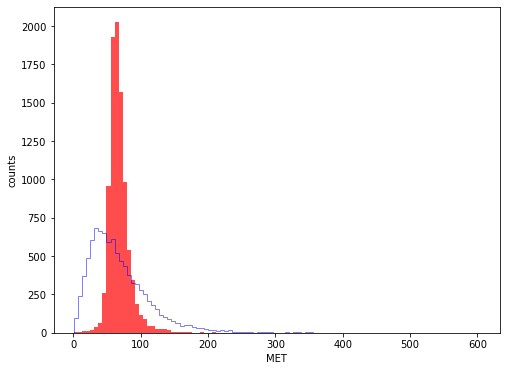

In [65]:
######################################################################
#Linear regression
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Linear regression
lr_model = linear_model.LinearRegression()
lr_model.fit(x_train, y_train)
y_pred_lr = lr_model.predict(x_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print('Mean squared error from linear regression: ', mse_lr)
print('Mean absolute error from linear regression: ', mae_lr)

    
fig = plt.figure(figsize =(8, 6))
_,bins,_ = plt.hist(y_test, bins=100, alpha=0.5, histtype='step', color='Blue')
_ = plt.hist(y_pred_lr, bins=bins,alpha=0.7, color='red')
plt.xlabel(f"MET")
plt.ylabel("counts")
#plt.savefig(f"{output_path}/pred_met.pdf")

Text(0, 0.5, 'counts')

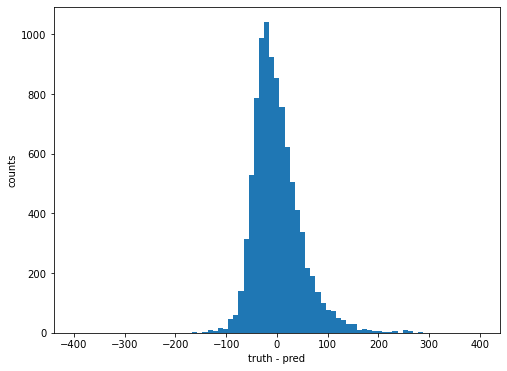

In [6]:
#Diff between pred and truth
delta = y_test-y_pred_lr
#gc.collect()
fig = plt.figure(figsize =(8, 6))
_= plt.hist(delta, bins=np.linspace(-400,400,80))
plt.xlabel("truth - pred")
plt.ylabel("counts")

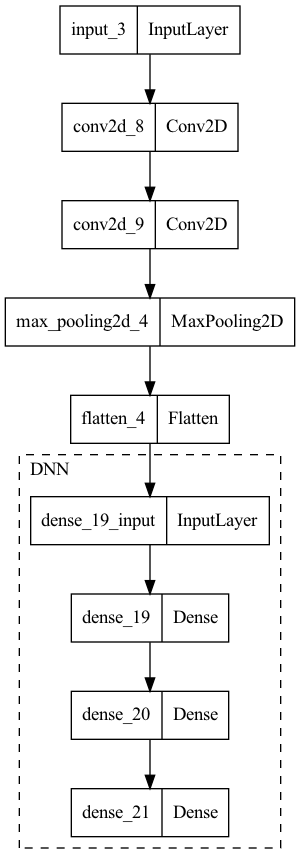

In [31]:
##############
###########DNN
x_train, x_test, y_train, y_test = train_test_split(cell_imgs, cell_label,
                                                       test_size=0.2, random_state=42,
                                                        shuffle=True
                                                       )
_cnn_dim = (-1,x_train.shape[-2],x_train.shape[-1],1)
x_train, x_test = x_train.reshape(_cnn_dim), x_test.reshape(_cnn_dim)
x=tf.keras.Input(shape=x_train.shape[1:] )
conv1 = tf.keras.layers.Conv2D(1, 2, strides=2,
                               activation='relu')(x)
#max_pool1=tf.keras.layers.MaxPooling2D((3, 3))(conv1)
conv2 =  tf.keras.layers.Conv2D( 3, 3,
                                activation='relu')(conv1)
max_pool2=tf.keras.layers.MaxPooling2D((2, 2))(conv2)
conv_flattened = tf.keras.layers.Flatten()(max_pool2)
model_CNN = Model(
                inputs=x,
                outputs = models.DNN(h_dim=[500, 200], out_dim=cell_label.shape[1],
                                     activation='relu', 
                                     L1L2=tf.keras.regularizers.L1L2(l1=0, l2=0.1))(conv_flattened)
             )

loss="mean_squared_error",
model_CNN.compile(optimizer=Adam(learning_rate=1e-3),
              loss=loss, 
              metrics=["mean_absolute_error"] 
             )

gc.collect()

tf.keras.utils.plot_model(model_CNN, expand_nested=True)

#history = train_dnn_model(model_CNN, x_train, y_train,
#                epochs=200, 
#                model_path='outputs_et/CNN500_200_MSE',
#                train=True,
#                best_model=True)


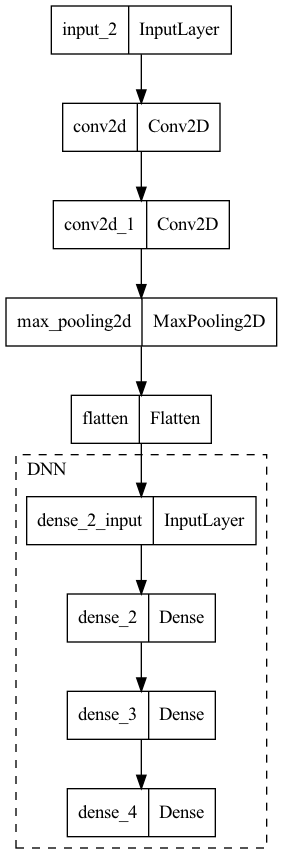

In [8]:
tf.keras.utils.plot_model(model_CNN, expand_nested=True)

<AxesSubplot:>

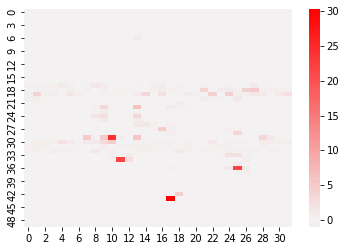

In [62]:
cmap = sns.diverging_palette(250, 20,s=500, as_cmap=True)
#sns.diverging_palette(250, 20, as_cmap=True)
#sns.diverging_palette(h_neg=130, h_pos=10, s=99, l=55, sep=3)
hit = cell_imgs[6,:,:]
#hit[hit<0.001]=0
sns.heatmap(hit, cmap=cmap, center=0.00)

In [53]:
print(cell_imgs[4,1,1])

0.0


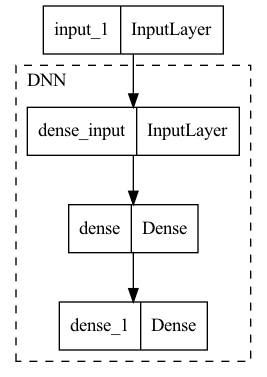

In [66]:
tf.keras.utils.plot_model(model_DNN, expand_nested=True)

In [55]:
import models

In [66]:
model = models.model_combined([200,200],1,2, (50,40,1), model_type='dnn',output_type='combined')

In [54]:
model.

/Users/abletimin/cernbox/Trigger/ml-met-trigger/models/models.py:107: SyntaxWarning: "is" with a literal. Did you mean "=="?
  return _model
/Users/abletimin/cernbox/Trigger/ml-met-trigger/models/models.py:126: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/Users/abletimin/cernbox/Trigger/ml-met-trigger/models/models.py:127: SyntaxWarning: "is" with a literal. Did you mean "=="?


SyntaxError: invalid syntax (1068564517.py, line 1)

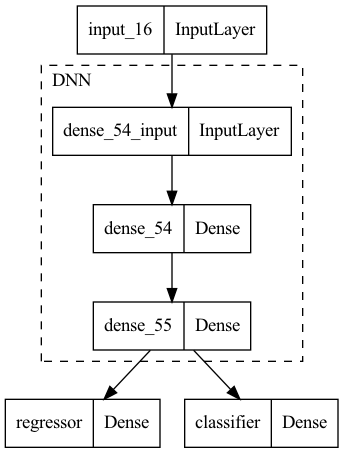

In [67]:
tf.keras.utils.plot_model(model, expand_nested=True)

In [41]:
model.layers